## <font color='turquoise'> Inter-subject Correlation</font>

We again want to mask out our clips, but this time we want on the the NIM set of clips - the _non-internal monologue segments_, and we want the voxel-wise average across time. 

In [2]:
import os
import glob
import pandas as pd 
import numpy as np
from natsort import natsorted
import statsmodels.api as sm

#Brain packages
import nibabel as nb
import nilearn
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

In [2]:
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
                                                    data_dir=None, base_url=None, resume=True, verbose=1)
'''
From the documentation:
The list of labels does not contain ‘Background’ by default. 
To have proper indexing, you should either manually add ‘Background’ to the list of labels:
'''

masker = NiftiLabelsMasker(
    labels_img=schaefer_atlas.maps,
    strategy='mean',  # Averages voxels in parcel at each TR
    standardize=False  # don't want z-scoring
)

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


In [3]:
version_matrix = np.loadtxt("version_matrix.csv",delimiter=",", dtype=int, encoding='utf-8-sig')

### <font color='red'>Non-Internal Monologues ISC Analyses</font> 
In this analysis, we perform an inter-subject correlation between subjects who have seen the same version of the movie stimuli, while also controlling for the potential influence of the inner monologues they would have potentially received. This is to investigate whether watching the same version of the 

In [5]:
segmented_clip_path = '/Volumes/Scraplab/fSEND/inarr_data/'
sublist = [x for x in os.listdir(segmented_clip_path) if 'sub' in x]
complete_cliplist = []

#compile all of the clip files across subjects
for sub in sublist:
    try:
        segment_list = [x for x in os.listdir(segmented_clip_path+sub+os.sep+"segmented_files/") if "_NIM" in x] # [ IM / NIM ]
        discard_first_clip = [x for x in segment_list if "_clip-0_" not in x]

        for f in discard_first_clip:
            complete_cliplist.append(f)
    except:
        continue

movie_list = ['physical', 'stutterer']

#we don't include the very first clip, clip-0:
nim_clips = ['clip-2','clip-4','clip-6','clip-8','clip-10','clip-12',
             'clip-14','clip-16','clip-18','clip-20','clip-22','clip-24']

im_clips = ['clip-1','clip-3','clip-5','clip-7','clip-9','clip-11','clip-13',
             'clip-15','clip-17','clip-19','clip-21','clip-23']

In [ ]:
for movie in movie_list[0:1]:
    #all the subject's clips corresponding to stutterer, for example
    movie_cliplist = [x for x in complete_cliplist if movie in x]

    clip_to_version_correlation = np.zeros([12,400]) #NIM is 12 clips without the first one

    for ix, i in enumerate(nim_clips[0:1]):

        #all 28 subjects clip-1's for example
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]

        #doing this ensures that my resulting matrix is in the *same exact order* as our version matrix
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = [] #this will be len(28) for each subject!
        preceding_clip_matrix_list = []

        for clip in v1_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)
            preceding_clip = glob.glob(segmented_clip_path+sub+'/segmented_files/'+sub+"_"+movie+"_"+im_clips[ix]+"_IM_version-1*.nii.gz")[0]
            preceding_clip_nii = nb.load(preceding_clip))

            """ 
            masker.fit_transform(clip_segment_nii) will take the voxelwise mean (ie it preserves
            timecourse information). This produces a timepoint x parcel csv, eg for physical's 
            clip_0, it will generate a (74,40) shape.
            """

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            time_by_parcel_preceding_clip = masker.fit_transform(preceding_clip_nii)

            single_clip_matrix_list.append(time_by_parcel)
            preceding_clip_matrix_list.append(time_by_parcel_preceding_clip)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)
            preceding_clip = glob.glob(segmented_clip_path+sub+'/segmented_files/'+sub+"_"+movie+"_"+im_clips[ix]+"_IM_version-2*.nii.gz")[0]
            preceding_clip_nii = nb.load(preceding_clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            time_by_parcel_preceding_clip = masker.fit_transform(preceding_clip_nii)

            single_clip_matrix_list.append(time_by_parcel)
            preceding_clip_matrix_list.append(time_by_parcel_preceding_clip)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list) #shape is (28, TR, 400) so for clip-2 its: (28,14,400)
        preceding_clip_mat_arr = np.array(preceding_clip_matrix_list)

        for p in range(400)[0:1]:
            sub_clip_corr = np.corrcoef(single_clip_mat_arr[:,:,p]) #(28,28)
            im_clips_corr = np.corrcoef(preceding_clip_mat_arr[:,:,p]) #also (28,28)
            
            #regress out the IM signal 
            nim_flat, im_flat = sub_clip_corr.flatten(), im_clips_corr.flatten()
            const = im_const = sm.add_constant(im_flat)
            model = sm.OLS(nim_flat, im_const)
            results = model.fit()
            residuals = results.resid
            cleaned_nim = residuals.reshape(28, 28)
            

            neural_lower = nilearn.connectome.sym_matrix_to_vec(cleaned_nim, discard_diagonal=True)
            version_lower = nilearn.connectome.sym_matrix_to_vec(version_matrix, discard_diagonal=True)

            result = np.corrcoef(neural_lower, version_lower)[0][1]
            clip_to_version_correlation[ix,p] = result

    output = pd.DataFrame(clip_to_version_correlation) #(12,400), 12 clips 400 parcels
    output.to_csv(movie+"_parcel_CLEANED_NIM_ISC.csv")

starting clip: clip-2


### <font color='teal'>Permutation Analyses</font>

In [ ]:
for movie in movie_list:

    #all the clips corresponding to stutterer, for example, across all 28 subs
    movie_cliplist = [x for x in complete_cliplist if movie in x]

    clip_to_version_permutations = np.zeros([12,400,10000]) # (n. NIM clips, n. parcels, n. perms)

    for ix, i in enumerate(nim_clips):

        #all 28 subjects clip-1's, for example
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]

        #doing this ensures that my resulting matrix is in the *same exact order* as our version matrix
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = []
        preceding_clip_matrix_list = []

        for clip in v1_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(andes_path+sub+'/segmented_files/'+clip)
            preceding_clip = glob.glob(andes_path+sub+'/segmented_files/'+sub+"_"+movie+"_"+im_clips[ix]+"_IM_version-1*.nii.gz")[0]
            preceding_clip_nii = nb.load(preceding_clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            time_by_parcel_preceding_clip = masker.fit_transform(preceding_clip_nii)

            single_clip_matrix_list.append(time_by_parcel)
            preceding_clip_matrix_list.append(time_by_parcel_preceding_clip)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(andes_path+sub+'/segmented_files/'+clip)
            preceding_clip = glob.glob(andes_path+sub+'/segmented_files/'+sub+"_"+movie+"_"+im_clips[ix]+"_IM_version-2*.nii.gz")[0]
            preceding_clip_nii = nb.load(preceding_clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            time_by_parcel_preceding_clip = masker.fit_transform(preceding_clip_nii)

            single_clip_matrix_list.append(time_by_parcel)
            preceding_clip_matrix_list.append(time_by_parcel_preceding_clip)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list)
        preceding_clip_mat_arr = np.array(preceding_clip_matrix_list)

        for p in range(400):
            np.random.seed(0)

            sub_clip_corr = np.corrcoef(single_clip_mat_arr[:,:,p]) #(28,28)
            im_clips_corr = np.corrcoef(preceding_clip_mat_arr[:,:,p]) # also (28,28)
            
            #regress out the IM signal 
            nim_flat, im_flat = sub_clip_corr.flatten(), im_clips_corr.flatten()
            const = im_const = sm.add_constant(im_flat)
            model = sm.OLS(nim_flat, im_const)
            results = model.fit()
            residuals = results.resid
            cleaned_nim = residuals.reshape(28, 28)

            for perm in range(10000):
                random_array = np.random.permutation(28)
                shuffled_matrix = sub_clip_corr[random_array][:, random_array]
            
                #contrast neural signals based on which version the subject saw
                neural_lower = nilearn.connectome.sym_matrix_to_vec(shuffled_matrix, discard_diagonal=True)
                version_lower = nilearn.connectome.sym_matrix_to_vec(version_matrix, discard_diagonal=True)

                result = np.corrcoef(neural_lower, version_lower)[0][1]
                clip_to_version_permutations[ix,p,perm] = result
        
    np.save(movie+'_isc_nim_cleaned_permutation_matrix', clip_to_version_permutations.mean(axis=0)) #average across clips

### <font color='teal'>Plotting the Results</font>

In [1]:
from statsmodels.stats.multitest import multipletests
from nilearn import plotting, datasets, image, surface
import nibabel as nb
from nilearn.plotting import plot_img_on_surf
from nilearn.image import new_img_like
import matplotlib.pyplot as plt

fsaverage = datasets.fetch_surf_fsaverage()

In [15]:
#load observed values
phys_isc, stut_isc = pd.read_csv('outputs/physical_parcel_CLEANED_NIM_ISC.csv', index_col=0), pd.read_csv('outputs/stutterer_parcel_CLEANED_NIM_ISC.csv', index_col=0)
phys_isc_avg, stut_isc_avg = phys_isc.mean(axis=0).reset_index(drop=True), stut_isc.mean(axis=0).reset_index(drop=True)
isc_avg = np.array((phys_isc_avg + stut_isc_avg) / 2) #shape (400)

#load permutated values
phys_perm = np.load('outputs/physical_isc_nim_cleaned_permutation_matrix.npy') # (400, 10000)
stut_perm = np.load('outputs/stutterer_isc_nim_cleaned_permutation_matrix.npy')
perm_avg = np.mean([phys_perm, stut_perm], axis=0) #shape (400, 10000)

permuted_vals = np.abs(perm_avg)
null_dist = permuted_vals.max(axis=0) #shape (10000) 

results_pvals = np.empty((400))

for parcel in range(isc_avg.shape[0]): #400, for each parcel
    results_pvals[parcel] = np.mean(null_dist >= abs(isc_avg[parcel]))

significant = np.where(results_pvals < 0.05, 1, 0)

In [16]:
#create correlation value image

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
    data_dir=None, base_url=None, resume=True, verbose=1)

#need to insert the 0 for proper indexing. 
schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = isc_avg[i]

nim_corr_img = nb.Nifti1Image(mapped_data, atlas.affine)
nb.save(nim_corr_img, 'outputs/nim_corr_cleaned_map.nii.gz')

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


In [17]:
#Create corrected p-value mask:
n_rois = 399

roi_data = image.get_data(atlas)  # (x,y,z) array with ROI labels
significant_mask = np.zeros_like(roi_data, dtype=np.float32)

for roi_label in range(1, n_rois+1):
    if significant[roi_label-1] == 1:  # ROI labels start at 1
        significant_mask[roi_data == roi_label] = 1  # Tag significant voxels

mask_img = new_img_like(atlas, significant_mask)

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


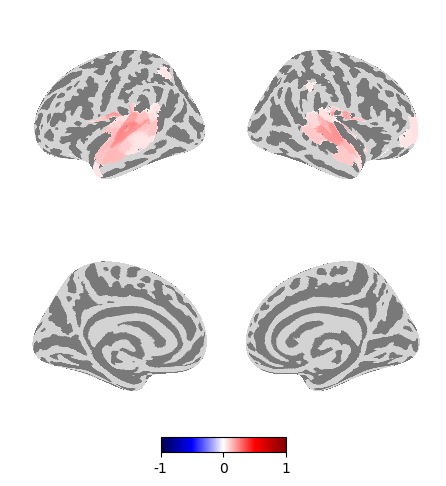

In [18]:
#plot results

plotting.plot_img_on_surf(nim_corr_img,
    "fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    mask_img=mask_img,
    vmin=-1, vmax=1, 
)

# fig = plt.gcf()
# fig.savefig('isc_corrected.png', dpi=300, facecolor='w', bbox_inches='tight')
# plt.close()

plotting.show()

# Sanity Checks

### <font color='red'>Non-Internal Monologues ISC Analyses</font> 
This is a primary analysis.

In [ ]:
segmented_clip_path = '/Volumes/Scraplab/fSEND/inarr_data/'
sublist = [x for x in os.listdir(segmented_clip_path) if 'sub' in x]
complete_cliplist = []

#compile all of the clip files across subjects
for sub in sublist:
    try:
        segment_list = [x for x in os.listdir(segmented_clip_path+sub+os.sep+"segmented_files/") if "_NIM" in x] # [ IM / NIM ]
        discard_first_clip = [x for x in segment_list if "_clip-0_" not in x]

        for f in discard_first_clip:
            complete_cliplist.append(f)
    except:
        continue

movie_list = ['physical', 'stutterer']

#we don't include the very first clip, clip-0:
nim_clips = ['clip-2','clip-4','clip-6','clip-8','clip-10','clip-12',
             'clip-14','clip-16','clip-18','clip-20','clip-22','clip-24']

im_clips = ['clip-1','clip-3','clip-5','clip-7','clip-9','clip-11','clip-13',
             'clip-15','clip-17','clip-19','clip-21','clip-23']

In [ ]:
for movie in movie_list:
    #all the subject's clips corresponding to stutterer, for example
    movie_cliplist = [x for x in complete_cliplist if movie in x]

    clip_to_version_correlation = np.zeros([12,400]) #NIM is 12 clips without the first one

    for ix, i in enumerate(nim_clips):
        print("starting clip:", i)

        #all 28 subjects clip-1's for example
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]

        #doing this ensures that my resulting matrix is in the *same exact order* as our version matrix
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = [] #this will be len(28) for each subject!

        for clip in v1_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            """ 
            masker.fit_transform(clip_segment_nii) will take the voxelwise mean (ie it preserves
            timecourse information). This produces a timepoint x parcel csv, eg for physical's 
            clip_0, it will generate a (74,40) shape.
            """

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)

            single_clip_matrix_list.append(time_by_parcel)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)

            single_clip_matrix_list.append(time_by_parcel)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list) #shape is (28, TR, 400) so for clip-2 its: (28,14,400)

        for p in range(400):
            sub_clip_corr = np.corrcoef(single_clip_mat_arr[:,:,p]) #(28,28)

            neural_lower = nilearn.connectome.sym_matrix_to_vec(sub_clip_corr, discard_diagonal=True)
            version_lower = nilearn.connectome.sym_matrix_to_vec(version_matrix, discard_diagonal=True)

            result = np.corrcoef(neural_lower, version_lower)[0][1]
            clip_to_version_correlation[ix,p] = result

    output = pd.DataFrame(clip_to_version_correlation) #(12,400), 12 clips 400 parcels
    output.to_csv(movie+"_parcel_NIM_ISC.csv")

    #takes an hour to run locally

### <font color='red'>Internal Monologues ISC Analyses</font> 
This is a secondary analysis. The primary hypothesis is about the non-internal monologues with regards to the intersubject correlation.

In [ ]:
segmented_clip_path = '/Volumes/Scraplab/fSEND/inarr_data/'
sublist = [x for x in os.listdir(segmented_clip_path) if 'sub' in x]
complete_cliplist = []

#compile all of the clip files across subjects
for sub in sublist:
    try:
        segment_list = [x for x in os.listdir(segmented_clip_path+sub+os.sep+"segmented_files/") if "_IM_" in x] # [ IM / NIM ]
        #discard_first_clip = [x for x in segment_list if "_clip-0_" not in x]

        for f in segment_list:
            complete_cliplist.append(f)
    except:
        continue

movie_list = ['physical', 'stutterer']

#we don't include the very first clip, clip-0:
im_clips = ['clip-1','clip-3','clip-5','clip-7','clip-9','clip-11','clip-13',
             'clip-15','clip-17','clip-19','clip-21','clip-23']

for movie in movie_list:
    #all the subject's clips corresponding to stutterer, for example
    movie_cliplist = [x for x in complete_cliplist if movie in x]

    clip_to_version_correlation = np.zeros([12,400]) #IM is 12 clips

    for ix, i in enumerate(im_clips):
        print("starting clip:", i)

        #all 28 subjects clip-1's for example
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]

        #doing this ensures that my resulting matrix is in the *same exact order* as our version matrix
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = [] #this will be len(28) for each subject!

        for clip in v1_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            """ 
            masker.fit_transform(clip_segment_nii) will take the voxelwise mean (ie it preserves
            timecourse information). This produces a timepoint x parcel csv, eg for physical's 
            clip_0, it will generate a (74,40) shape.
            """

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]
            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list) #shape is (28, TR, 400) so for clip-2 its: (28,14,400)

        for p in range(400):
            sub_clip_corr = np.corrcoef(single_clip_mat_arr[:,:,p]) #(28,28)

            neural_lower = nilearn.connectome.sym_matrix_to_vec(sub_clip_corr, discard_diagonal=True)
            version_lower = nilearn.connectome.sym_matrix_to_vec(version_matrix, discard_diagonal=True)

            result = np.corrcoef(neural_lower, version_lower)[0][1]
            clip_to_version_correlation[ix,p] = result

    output = pd.DataFrame(clip_to_version_correlation) #(12,400), 12 clips 400 parcels
    output.to_csv(movie+"_parcel_IM_ISC.csv")

    #takes an hour to run locally

### <font color='teal'>Plotting the Sanity Checks Analyses</font>

In [ ]:
from statsmodels.stats.multitest import multipletests
from nilearn import plotting, datasets, image, surface
import nibabel as nb
from nilearn.plotting import plot_img_on_surf
from nilearn.image import new_img_like
import matplotlib.pyplot as plt

fsaverage = datasets.fetch_surf_fsaverage()

**<font color='darkgoldenrod'>Non-internal monologues</font>**

In [ ]:
#load observed values
phys_isc, stut_isc = pd.read_csv('outputs/physical_parcel_NIM_ISC.csv', index_col=0), pd.read_csv('outputs/stutterer_parcel_NIM_ISC.csv', index_col=0)
phys_isc_avg, stut_isc_avg = phys_isc.mean(axis=0).reset_index(drop=True), stut_isc.mean(axis=0).reset_index(drop=True)
isc_avg = np.array((phys_isc_avg + stut_isc_avg) / 2) #shape (400)

#load permutated values
phys_perm = np.load('/Volumes/Scraplab/lindseytepfer/inarr/physical_isc_nim_permutation_matrix.npy') # (400, 10000)
stut_perm = np.load('/Volumes/Scraplab/lindseytepfer/inarr/stutterer_isc_nim_permutation_matrix.npy')
perm_avg = np.mean([phys_perm, stut_perm], axis=0) #shape (400, 10000)

permuted_vals = np.abs(perm_avg)
null_dist = permuted_vals.max(axis=0) #shape (10000) 

results_pvals = np.empty((400))

for parcel in range(isc_avg.shape[0]): #400, for each parcel
    results_pvals[parcel] = np.mean(null_dist >= abs(isc_avg[parcel]))

significant = np.where(results_pvals < 0.05, 1, 0)

In [ ]:
#create correlation value image

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
    data_dir=None, base_url=None, resume=True, verbose=1)

#need to insert the 0 for proper indexing. 
schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = isc_avg[i]

nim_corr_img = nb.Nifti1Image(mapped_data, atlas.affine)
nb.save(nim_corr_img, 'outputs/nim_corr_map.nii.gz')

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


In [ ]:
#Create corrected p-value mask:
n_rois = 399

roi_data = image.get_data(atlas)  # (x,y,z) array with ROI labels
significant_mask = np.zeros_like(roi_data, dtype=np.float32)

for roi_label in range(1, n_rois+1):
    if significant[roi_label-1] == 1:  # ROI labels start at 1
        significant_mask[roi_data == roi_label] = 1  # Tag significant voxels

mask_img = new_img_like(atlas, significant_mask)

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


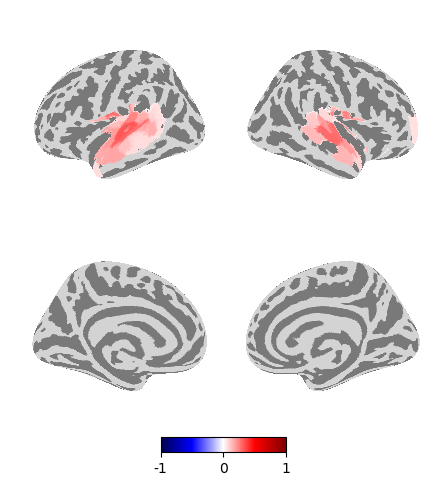

In [ ]:
#plot results

plotting.plot_img_on_surf(nim_corr_img,
    "fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    #threshold=0.05,  # Highlight significant p-values
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    mask_img=mask_img,
    vmin=-1, vmax=1, #removing these options to let it be automatic
)

# fig = plt.gcf()
# fig.savefig('isc_corrected.png', dpi=300, facecolor='w', bbox_inches='tight')
# plt.close()

plotting.show()

**<font color='darkgoldenrod'>Internal monologues</font>**

In [ ]:
#load observed values
phys_isc, stut_isc = pd.read_csv('outputs/physical_parcel_IM_ISC.csv', index_col=0), pd.read_csv('outputs/stutterer_parcel_IM_ISC.csv', index_col=0)
phys_isc_avg, stut_isc_avg = phys_isc.mean(axis=0).reset_index(drop=True), stut_isc.mean(axis=0).reset_index(drop=True)
isc_avg = np.array((phys_isc_avg + stut_isc_avg) / 2) #shape (400)

#load permutated values
phys_perm = np.load('/Volumes/Scraplab/lindseytepfer/inarr/physical_isc_im_permutation_matrix.npy')
stut_perm = np.load('/Volumes/Scraplab/lindseytepfer/inarr/stutterer_isc_im_permutation_matrix.npy')
perm_avg = np.mean([phys_perm, stut_perm], axis=0) #shape (400, 10000)

permuted_vals = np.abs(perm_avg)
null_dist = permuted_vals.max(axis=0) #shape (10000) 

results_pvals = np.empty((400))

for parcel in range(isc_avg.shape[0]): #400, for each parcel
    results_pvals[parcel] = np.mean(null_dist[:] >= abs(isc_avg[parcel]))

significant = np.where(results_pvals < 0.01, 1, 0)

In [ ]:
#create correlation image

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
    data_dir=None, base_url=None, resume=True, verbose=1)

#need to insert the 0 for proper indexing. 
schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = isc_avg[i]

im_corr_img = nb.Nifti1Image(mapped_data, atlas.affine)
#nb.save(nim_corr_img, 'tvalue_map.nii.gz')

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


In [ ]:
#Create corrected p-value mask:
n_rois = 399

roi_data = image.get_data(atlas)  # (x,y,z) array with ROI labels
significant_mask = np.zeros_like(roi_data, dtype=np.float32)

for roi_label in range(1, n_rois+1):
    if significant[roi_label-1] == 1:  # ROI labels start at 1
        significant_mask[roi_data == roi_label] = 1  # Tag significant voxels

mask_img = new_img_like(atlas, significant_mask)

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


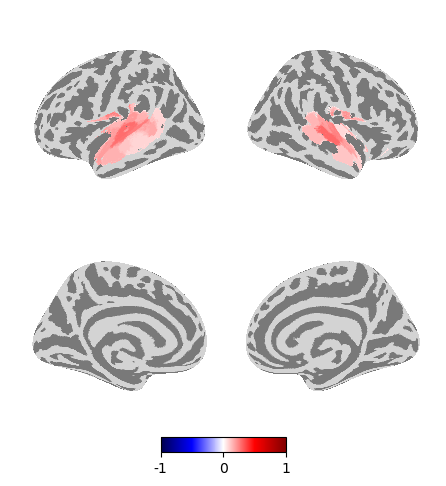

In [ ]:
#plot results

plotting.plot_img_on_surf(im_corr_img,
    "fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    #threshold=0.05,  # Highlight significant p-values
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    mask_img=mask_img,
    vmin=-1, vmax=1, #removing these options to let it be automatic
)

# fig = plt.gcf()
# fig.savefig('isc_corrected.png', dpi=300, facecolor='w', bbox_inches='tight')
# plt.close()

plotting.show()